In [1]:
import datetime
import shutil
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
from torch.nn import functional as F
from tqdm import tqdm
import os
from torch.utils.data import ConcatDataset
from einops import rearrange, repeat
from einops.layers.torch import Rearrange
import matplotlib.pyplot as plt

torch.manual_seed(1337)

LEARNING_RATE = 3e-5
BATCH_SIZE = 128
BLOCK_SIZE = 128
IMAGE_SIZE = 129 + 12
CHANNELS_IMG = 3

N_EMBD = 128
N_HEAD = 6
N_LAYER = 6
DROPOUT = 0.2

VERSION = "2.1.6.3_bigData"

@torch.no_grad()
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

def model_saveFile(version, train):
    return f"model/model{train}{VERSION}_FloorEP{version}.pth"

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("device: ",device)

@torch.no_grad()
def validate(model, dataloader):
    total_loss = 0
    total_samples = 0
    for idx, (data, _) in enumerate(dataloader):
        dataRaw = data.squeeze(0).to(device)
        x, y = get_batch(dataRaw)
        
        _, loss = model(x, y)

        total_loss += loss.item()
        total_samples += 1
    return total_loss / total_samples


class Head(nn.Module):
    """ one head of self-attention """

    def __init__(self, head_size):
        super().__init__()
        self.key = nn.Linear(N_EMBD, head_size, bias=False)
        self.query = nn.Linear(N_EMBD, head_size, bias=False)
        self.value = nn.Linear(N_EMBD, head_size, bias=False)
        self.register_buffer('tril', torch.tril(torch.ones(BLOCK_SIZE, BLOCK_SIZE)))

        self.dropout = nn.Dropout(DROPOUT)

    def forward(self, x):
        # input of size (batch, time-step, channels)
        # output of size (batch, time-step, head size)
        B,T,C = x.shape
        k = self.key(x)   # (B,T,hs)
        q = self.query(x) # (B,T,hs)
        # compute attention scores ("affinities")
        wei = q @ k.transpose(-2,-1) * k.shape[-1]**-0.5 # (B, T, hs) @ (B, hs, T) -> (B, T, T)
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf')) # (B, T, T)
        wei = F.softmax(wei, dim=-1) # (B, T, T)
        wei = self.dropout(wei)
        # perform the weighted aggregation of the values
        v = self.value(x) # (B,T,hs)
        out = wei @ v # (B, T, T) @ (B, T, hs) -> (B, T, hs)
        return out

class MultiHeadAttention(nn.Module):
    """ multiple heads of self-attention in parallel """

    def __init__(self, num_heads, head_size):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size) for _ in range(num_heads)])
        self.proj = nn.Linear(head_size * num_heads, N_EMBD)
        self.dropout = nn.Dropout(DROPOUT)

    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1)
        out = self.dropout(self.proj(out))
        return out

class FeedFoward(nn.Module):
    """ a simple linear layer followed by a non-linearity """

    def __init__(self, n_embd):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd),
            nn.ReLU(),
            nn.Linear(4 * n_embd, n_embd),
            nn.Dropout(DROPOUT),
        )

    def forward(self, x):
        return self.net(x)

class Block(nn.Module):
    """ Transformer block: communication followed by computation """

    def __init__(self, n_embd, n_head):
        # n_embd: embedding dimension, n_head: the number of heads we'd like
        super().__init__()
        head_size = n_embd // n_head
        self.sa = MultiHeadAttention(n_head, head_size)
        self.ffwd = FeedFoward(n_embd)
        self.ln1 = nn.LayerNorm(n_embd)
        self.ln2 = nn.LayerNorm(n_embd)

    def forward(self, x):
        x = x + self.sa(self.ln1(x))
        x = x + self.ffwd(self.ln2(x))
        return x
        
class ColumnTransformer(nn.Module):

    def __init__(self):
        super().__init__()
        self.pixel_embedding = nn.Sequential(
            nn.Linear(CHANNELS_IMG, N_EMBD//5, device = device),
            nn.ReLU(),
            nn.Linear(N_EMBD//5, N_EMBD//2, device = device),
            nn.ReLU(),
            nn.Linear(N_EMBD//2, N_EMBD, device = device),
            nn.Dropout(DROPOUT),
        )
        self.position_embedding_table = nn.Embedding(BLOCK_SIZE, N_EMBD)
        self.blocks = nn.Sequential(*[Block(N_EMBD, n_head=N_HEAD) for _ in range(N_LAYER)])
        self.ln_f = nn.LayerNorm(N_EMBD) # final layer norm
        self.lm_head = nn.Sequential(
            nn.Linear(N_EMBD, N_EMBD//2, device=device),
            nn.ReLU(),
            nn.Linear(N_EMBD//2, N_EMBD//5, device=device),
            nn.ReLU(),
            nn.Linear(N_EMBD//5, CHANNELS_IMG, device=device),
            nn.Sigmoid(),
        )

        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)


    def forward(self, idx, targets=None):
        B, H, C = idx.shape
        
        tok_emb = self.pixel_embedding(idx) # (B, H, N_EMBD)
        pos_emb = self.position_embedding_table(torch.arange(H, device=device)) # (H, N_EMBD)

        x = tok_emb + pos_emb # (B,H,N_EMBD)


        x = self.blocks(x) # (B,H,N_EMBD)
        x = self.ln_f(x) # (B,H,N_EMBD)
        logits = self.lm_head(x) # (B,H,C)

        if targets is None:
            loss = None
        else:
            # B, T, C = logits.shape
            loss = F.mse_loss(logits, targets)
            
        return logits, loss


transform = transforms.Compose(
    [
        transforms.RandomCrop(IMAGE_SIZE),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.ToTensor(),
    ]
)

print(f'BLOCK_SIZE: {BLOCK_SIZE}, BATCH_SIZE: {BATCH_SIZE}, CHANNELS_IMG: {CHANNELS_IMG}, IMAGE_SIZE: {IMAGE_SIZE}, N_EMBD: {N_EMBD}')

m = ColumnTransformer()
m = m.to(device)

#print parameterscount
print(f'Model has {count_parameters(m):,} trainable parameters')

@torch.no_grad()
def get_batch(data):
    # C ,H ,W = data.shape

    x = data[:, :BLOCK_SIZE, :BATCH_SIZE]
    y = data[:, 1:BLOCK_SIZE*2+1, :BATCH_SIZE]

    x, y = x.to(device), y.to(device)
    x = rearrange(x, 'c h b -> b h c')
    y = rearrange(y, 'c h b -> b h c')
    return x, y



device:  cuda
BLOCK_SIZE: 128, BATCH_SIZE: 128, CHANNELS_IMG: 3, IMAGE_SIZE: 141, N_EMBD: 128
Model has 1,217,867 trainable parameters


device:  cuda


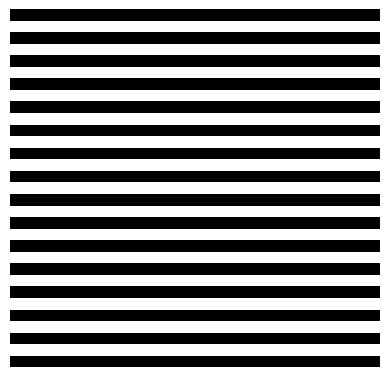

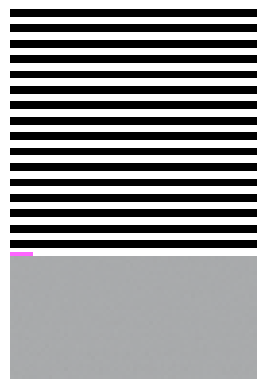

In [51]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms
from PIL import Image

m = torch.load(f"tempModel/modelpostTrain2.1.6.3_bigData_FloorEP0.pth").to(device)

def create_striped_tensor(width, height, stripe_width):
    tensor = torch.zeros(1, 3, height, width, dtype=torch.uint8, device=device)

    # Create stripes
    for row in range(height):
        if (row // stripe_width) % 2 != 0:
            tensor[:, :, row, :] = 1  # White stripe

    return tensor

with torch.no_grad():
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    print("device: ",device)


    zebra_tensor = rearrange(create_striped_tensor(width=64, height=64, stripe_width=2), '1 c h w -> 1 c h w')

    # Displaying the tensor as an image
    plt.imshow((rearrange(zebra_tensor, '1 c h w -> h w c')* 255).cpu().detach().numpy().astype('int'))
    plt.axis('off')  # Turn off axis numbers
    plt.show()

    size_x = 128
    size_y = 128

    gen_length = 32


    img_tensor = zebra_tensor.squeeze(0).to(device)
    img_tensor = img_tensor[:3,:,:] # Remove alpha channel
    
    C, H, W = img_tensor.shape

    img_gen = torch.zeros((C,H+gen_length,W)).to(device)
    img_gen[:,:H,:] = img_tensor


    for igen in range(gen_length):
        
        a = img_gen[:,igen:H+igen,:] # (C, H, W) 
        gen, _ = m(rearrange(a, 'c h w -> w h c')) # B, H, C 

        img_gen[:,H+igen,:] = rearrange(gen[:,-1,:], ' w c -> c w')

    
    img_gen = img_gen.squeeze(0) * 255
    
    image = rearrange(img_gen, 'c h w -> h w c').cpu().detach().numpy()
    image = image.astype(np.uint8)

    image[H-1, :6] = [255, 100, 255]

    plt.imshow(image)
    plt.axis('off')  # Turn off axis numbers
    plt.show()



device:  cuda


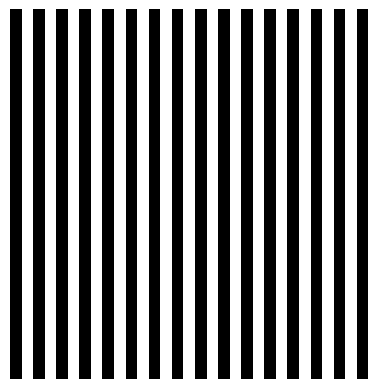

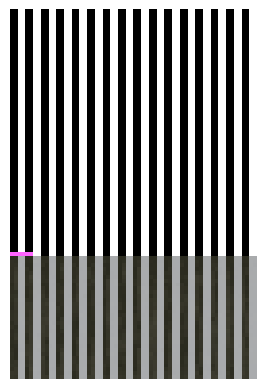

In [54]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms
from PIL import Image

m = torch.load(f"tempModel/modelpostTrain2.1.6.3_bigData_FloorEP0.pth").to(device)

def create_striped_tensor(width, height, stripe_width):
    tensor = torch.zeros(1, 3, height, width, dtype=torch.uint8, device=device)

    # Create stripes
    for row in range(height):
        if (row // stripe_width) % 2 != 0:
            tensor[:, :, row, :] = 1  # White stripe

    return tensor

with torch.no_grad():
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    print("device: ",device)


    zebra_tensor = rearrange(create_striped_tensor(width=64, height=64, stripe_width=2), '1 c h w -> 1 c w h')

    # Displaying the tensor as an image
    plt.imshow((rearrange(zebra_tensor, '1 c h w -> h w c')* 255).cpu().detach().numpy().astype('int'))
    plt.axis('off')  # Turn off axis numbers
    plt.show()

    size_x = 128
    size_y = 128

    gen_length = 32


    img_tensor = zebra_tensor.squeeze(0).to(device)
    img_tensor = img_tensor[:3,:,:] # Remove alpha channel
    
    C, H, W = img_tensor.shape

    img_gen = torch.zeros((C,H+gen_length,W)).to(device)
    img_gen[:,:H,:] = img_tensor


    for igen in range(gen_length):
        
        a = img_gen[:,igen:H+igen,:] # (C, H, W) 
        gen, _ = m(rearrange(a, 'c h w -> w h c')) # B, H, C 

        img_gen[:,H+igen,:] = rearrange(gen[:,-1,:], ' w c -> c w')

    
    img_gen = img_gen.squeeze(0) * 255
    
    image = rearrange(img_gen, 'c h w -> h w c').cpu().detach().numpy()
    image = image.astype(np.uint8)

    image[H-1, :6] = [255, 100, 255]

    plt.imshow(image)
    plt.axis('off')  # Turn off axis numbers
    plt.show()

